# 量子エクストリーム学習

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time 
import random
from qulacs import QuantumState
from qulacs import QuantumCircuit
from qulacs.gate import DenseMatrix
from qulacs.circuit import QuantumCircuitOptimizer
from qulacs import QuantumState
from qulacs.gate import Identity, X,Y,Z #パウリ演算子
from qulacs.gate import H,S,Sdag, sqrtX,sqrtXdag,sqrtY,sqrtYdag #1量子ビット Clifford演算
from qulacs.gate import T,Tdag #1量子ビット 非Clifford演算
from qulacs.gate import RX,RY,RZ #パウリ演算子についての回転演算
from qulacs.gate import CNOT, CZ, SWAP #2量子ビット演算
from qulacs import Observable

### 量子回路からの出力がどういった非線形な振る舞いをするかをみる

量子ビットと量子回路の確保

In [10]:
nqubits = 8
state = QuantumState(nqubits)
state.set_zero_state()
circuit = QuantumCircuit(nqubits)

観測量（量子コンピュータからの出力）を定義

In [11]:
from qulacs import Observable
coef = 1.0
Pauli_string_z0 = "Z 0"
Pauli_string_z1 = "Z 1"
ob_Z0 = Observable(nqubits)
ob_Z1 = Observable(nqubits)
ob_Z0.add_operator(coef,"Z 0")
ob_Z1.add_operator(coef,"Z 1")

量子回路を構成する

In [12]:
import math
#適当に使うものを定義
num_para = 1000
parameters = [random.random() for i in range(num_para)]
output = [[],[],[]]

`input_val`を受け取り、`parameters`でパラメータつけられた量子回路

In [31]:

def ParaQCircuit(parameters,input_val):
    value = [0.0]*2
    l = 0;
    
    state.set_zero_state()
    circuit = QuantumCircuit(nqubits)
    for j in range(nqubits):
        if j%2 == 0:
            circuit.add_gate(RY(j,(j/2.0+1.0)*math.acos(np.sqrt(input_val[1]))))
        else:
            circuit.add_gate(RY(j,(j+1)/2.0*math.acos(np.sqrt(input_val[0]))))
    
    for m in range(1):
        for j in range(2,nqubits-1):
            for k in range(2):

                circuit.add_gate(CZ(j,k))


                circuit.add_gate(RX(k,parameters[l]))
                l=l+1
                circuit.add_gate(RZ(k,parameters[l]))
                l=l+1
                circuit.add_gate(RX(k,parameters[l]))
                l=l+1

                circuit.add_gate(CZ(j,k))

                circuit.add_gate(RX(k,parameters[l]))
                l=l+1
                circuit.add_gate(RZ(k,parameters[l]))
                l=l+1
                circuit.add_gate(RX(k,parameters[l]))
                l=l+1

#    opt = QuantumCircuitOptimizer()
#    max_block_size = 2
#    opt.optimize(circuit, max_block_size)
    
    circuit.update_quantum_state(state) #構成されたcircuitを実行して状態を更新
    value[0] = ob_Z0.get_expectation_value(state)
    value[1] = ob_Z1.get_expectation_value(state)
    
    return value[0]
    

入力 (x_0 , x_1) に対する出力を計算する。

In [32]:
input1 = [0.01*i for i in range(100)]
input2 = [0.01*i for i in range(100)]
output = [[ParaQCircuit(parameters,[0.01*i,0.01*j]) for i in range(100)] for j in range(100)]

２次元に射影してプロット

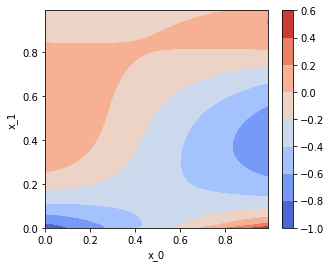

In [33]:
from mpl_toolkits.mplot3d import axes3d 
from matplotlib import cm 

plt.figure(figsize=(5,4))
plt.contourf(input1, input2, output, cmap=cm.coolwarm) 
plt.colorbar()
plt.xlabel("x_0")
plt.ylabel("x_1")
plt.savefig("sample.png",format = 'png', dpi=300)

量子回路からの出力はなかなか良さそうな非線形な関数になっている

### Scikit-learnを使って線形回帰をする

sklearnを使って線形回帰を使えるようにする。[ここ](https://pythondatascience.plavox.info/scikit-learn/線形回帰)を参照した。

データの取り込み。

In [36]:
import pandas as pd
import numpy as np
 
wine = pd.read_csv("winequality-red.csv", sep=";")

In [37]:
# sklearn.linear_model.LinearRegression クラスを読み込み
from sklearn import linear_model
clf = linear_model.LinearRegression()
 
# 説明変数に "density (濃度)" を利用
X = wine.loc[:, ['density']].values

# 目的変数に "alcohol (アルコール度数)" を利用
Y = wine['alcohol'].values
 
# 予測モデルを作成
clf.fit(X, Y)
 
# 回帰係数
print(clf.coef_)
 
# 切片 (誤差)
print(clf.intercept_)
 
# 決定係数
print(clf.score(X, Y))

[-280.16382307]
289.67534338256456
0.2461943643971065


### 量子エクストリーム学習をやる

各量子ビットからの出力を計算する関数を定義する。

In [40]:
def QEL_ParaQCircuit(parameters,input_val,nqubits):
    output_val = [0.0]*nqubits
    l = 0;
    
    state = QuantumState(nqubits)
    state.set_zero_state()
    circuit = QuantumCircuit(nqubits)
    for j in range(nqubits):
        if j%2 == 0:
            circuit.add_gate(RY(j,(j/2.0+1.0)*math.acos(np.sqrt(input_val[1]))))
        else:
            circuit.add_gate(RY(j,(j+1)/2.0*math.acos(np.sqrt(input_val[0]))))
    
    for m in range(1):
        for j in range(2,nqubits-1):
            for k in range(2):
                circuit.add_gate(CZ(j,k))

                circuit.add_gate(RX(k,parameters[l]))
                l=l+1
                circuit.add_gate(RZ(k,parameters[l]))
                l=l+1
                circuit.add_gate(RX(k,parameters[l]))
                l=l+1

                circuit.add_gate(CZ(j,k))

                circuit.add_gate(RX(k,parameters[l]))
                l=l+1
                circuit.add_gate(RZ(k,parameters[l]))
                l=l+1
                circuit.add_gate(RX(k,parameters[l]))
                l=l+1

#    opt = QuantumCircuitOptimizer()
#    max_block_size = 2
#    opt.optimize(circuit, max_block_size)
    
    circuit.update_quantum_state(state) #構成されたcircuitを実行して状態を更新
    
    #よみ出しの線形和


    
    for i in range(nqubits):
        readout = Observable(nqubits)
        readout.add_operator(1,"Z {0}".format(i))
        output_val[i] = readout.get_expectation_value(state)
    output_val.append(1)
    output_val.append(input_val[0])
    output_val.append(input_val[1])
    
    return output_val

きちんと動くか試してみる。

In [41]:
QEL_ParaQCircuit(parameters,[0.1,0.5],nqubits)

[0.1438568333846172,
 -0.5183383912053434,
 -1.0061396160665481e-16,
 -0.8000000000000007,
 -0.707106781186548,
 -0.8221921916437793,
 -1.0000000000000009,
 0.2800000000000002,
 1,
 0.1,
 0.5]

２次元の教師データを作る。

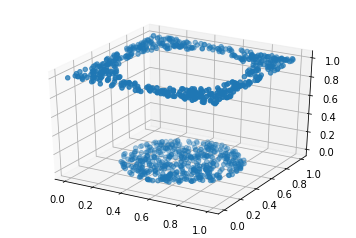

In [42]:
num_dataset = 1000
input0 = [random.random() for i in range(num_dataset)]
input1 = [random.random() for i in range(num_dataset)]
teacher = [0.0]*num_dataset

for i in range(num_dataset):
    if ((input0[i] - 0.5)**2 + (input1[i] - 0.5)**2) < 0.15:
        teacher[i]=0.0
    else:
        teacher[i]=1.0

from mpl_toolkits.mplot3d import Axes3D
 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(input0,input1,teacher) 
plt.show()
        

線形回帰のためのデータを生成する

In [43]:
nqubits = 8
X =[QEL_ParaQCircuit(parameters,[input0[i],input1[i]],nqubits) for i in range(num_dataset)]

比較用に量子回路からの出力がない単純な線形回帰のデータも用意しておく

In [44]:
X_LR =[[1.0,input0[i],input1[i]] for i in range(num_dataset)]

線形回帰する。

In [45]:
clf = linear_model.LinearRegression()
clf_LR = linear_model.LinearRegression()
  
# 予測モデルを作成
clf.fit(X, teacher)
clf_LR.fit(X_LR, teacher)
 
# 回帰係数
print(clf.coef_)
 
# 切片 (誤差)
print(clf.intercept_)

[ 3.12895194e-02  7.19610253e-02  6.00806322e+11  6.52632764e+11
 -5.29851037e-02 -1.31234361e-01  4.97712341e-01  5.55496358e-01
  7.32421875e-04 -1.30526553e+12 -1.20161264e+12]
1253439085536.2515


予測をする

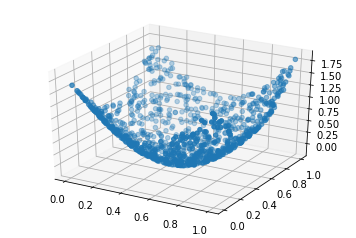

In [46]:
num_evaluation = 1000
input0 = [random.random() for i in range(num_evaluation)]
input1 = [random.random() for i in range(num_evaluation)]

X_eval = [QEL_ParaQCircuit(parameters,[input0[i],input1[i]],nqubits) for i in range(num_evaluation)]
Y_pred = clf.predict(X_eval)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(input0,input1,Y_pred)
plt.show()

0.5を閾値として1.0と0.0にする

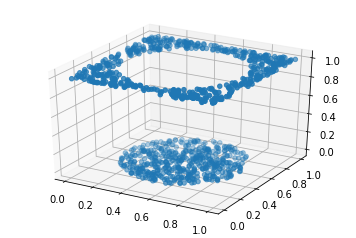

In [47]:
for i in range(num_evaluation):
    if Y_pred[i] >0.5: 
        Y_pred[i] = 1.0
    else:
        Y_pred[i] = 0.0
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(input0,input1,Y_pred)
plt.show()

正解した数をかぞえる

In [48]:
num_suc =0
for i in range(num_evaluation):
    if (input0[i]-0.5)**2 + (input1[i]-0.5)**2<0.15 and Y_pred[i] <0.5:
        num_suc = num_suc +1
    elif (input0[i]-0.5)**2 + (input1[i]-0.5)**2>0.15 and Y_pred[i] >0.5:
        num_suc = num_suc +1
print(num_suc)

973


正解率約97%

単純な線形回帰でどのくらいまでいくかみてみましょう。

In [49]:
X_LR =[[1.0,input0[i],input1[i]] for i in range(num_evaluation)]
Y_LR = clf_LR.predict(X_LR)

num_suc_LR =0
for i in range(num_evaluation):
    if (input0[i]-0.5)**2 + (input1[i]-0.5)**2<0.15 and Y_LR[i] <0.5:
        num_suc_LR = num_suc_LR +1
    elif (input0[i]-0.5)**2 + (input1[i]-0.5)**2>0.15 and Y_LR[i] >0.5:
        num_suc_LR = num_suc_LR +1
print(num_suc_LR)


543


単純な線形回帰だと正解率約54%。量子回路による非線形性によって分離能力が向上していることが確認できた。